In [554]:
import os
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from PIL import Image
import torch
import tqdm
import platform
import shutil
import json
import timm
from timm.loss import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt
import yaml
import numpy as np
import random
import math 

# https://github.com/facebookresearch/deit/blob/7e160fe43f0252d17191b71cbb5826254114ea5b/datasets.py#L108
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [555]:
# Make everything deterministic/reproducable
seed = 0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

Teaching team update the below cell with the paths to the parent directory of where the train and test data is

In [ ]:
# TODO: Update the below paths
data_prefix = "/mnt/c/Users/Michelle Quach/Desktop/UCSC/CSE244A/CSE244A-Final-Project/CSE244A-Final-Project/ucsc-cse-244-a-2024-fall-final-project"
model_prefix = "/mnt/c/Users/Michelle Quach/Desktop/UCSC/CSE244A/CSE244A-Final-Project/CSE244A-Final-Project/ucsc-cse-244-a-2024-fall-final-project/models/"
if platform.node() == 'navi': # Daniel
    data_prefix = "/home/argon/Stuff/CSE244A_project/"
    model_prefix = "/home/argon/Stuff/CSE244A_project/models/"

In [557]:
categories = pd.read_csv(os.path.join(data_prefix, 'categories.csv'))
train_labels = pd.read_csv(os.path.join(data_prefix, 'train_labeled.csv'))

In [558]:
def save_config(conf):
    with open(conf["model_name"] + ".yaml", 'w') as f:
        yaml.dump(conf, f)

def load_config(conf_name):
    with open(conf_name + ".yaml", 'r') as f:
        return yaml.safe_load(f)

In [559]:
# Someday this should probably be some yaml files... - Daniel

#TODO: Add batch size to this
#TODO: Add model type (e.g. facebookresearch/deit:main)

# training_config = {
#     "model_name":  "michelle_diet__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4",
#     "optimizer_type": "AdamW",
#     "optimizer_lr": 0.0001,
#     "optimizer_wd": 0.0001,
#     "scheduler_type": "ReduceLROnPlateau",
#     "scheduler_params": {"factor": 0.1,
#                          "patience": 0,
#                          "threshold": 0.0},
#     "unfreeze_layers": ['blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
# }
# save_config(training_config)
# training_config = load_config("michelle_diet__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4")

# training_config = load_config("michelle_diet_imagenetmean__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4")
# training_config = load_config("michelle_diet_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4")

# training_config = {
#     "model_name":  "michelle_diet_imagenetmean_augmentD__freeze10__explr_1en4_0.8__AdamW_wdecay_1en4",
#     "optimizer_type": "AdamW",
#     "optimizer_lr": 0.0001,
#     "optimizer_wd": 0.0001,
#     "augment_mode": "augmentD",
#     "scheduler_type": "ExponentialLR",
#     "scheduler_params": {"gamma": 0.8,},
#     "unfreeze_layers": ['blocks.10.norm1.weight', 'blocks.10.norm1.bias', 'blocks.10.attn.qkv.weight', 'blocks.10.attn.qkv.bias', 'blocks.10.attn.proj.weight', 'blocks.10.attn.proj.bias', 'blocks.10.norm2.weight', 'blocks.10.norm2.bias', 'blocks.10.mlp.fc1.weight', 'blocks.10.mlp.fc1.bias', 'blocks.10.mlp.fc2.weight', 'blocks.10.mlp.fc2.bias', 'blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
# }
# save_config(training_config)
# training_config = load_config("michelle_diet_imagenetmean_augmentD__freeze10__explr_1en4_0.8__AdamW_wdecay_1en4")

# Reproduce the best one?
# training_config = load_config("michelle_diet_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4")

# Distilled config
# training_config = load_config("michelle_distilled_diet_imagenetmean_augment__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4")

# Cosine annealing
# training_config = load_config("michelle_distilled_diet_imagenetmean_augmentD__freeze11__cosine_1en5_0.8__AdamW_wdecay_1en3")

# Higher res config
training_config = load_config("michelle_diet384_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4")

training_config

{'augment_mode': 'augmentD',
 'model_name': 'michelle_diet384_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4',
 'model': 'deit_384',
 'optimizer_lr': 0.0001,
 'optimizer_type': 'AdamW',
 'optimizer_wd': 0.0001,
 'scheduler_params': {'gamma': 0.8},
 'scheduler_type': 'ExponentialLR',
 'unfreeze_layers': ['blocks.11.norm1.weight',
  'blocks.11.norm1.bias',
  'blocks.11.attn.qkv.weight',
  'blocks.11.attn.qkv.bias',
  'blocks.11.attn.proj.weight',
  'blocks.11.attn.proj.bias',
  'blocks.11.norm2.weight',
  'blocks.11.norm2.bias',
  'blocks.11.mlp.fc1.weight',
  'blocks.11.mlp.fc1.bias',
  'blocks.11.mlp.fc2.weight',
  'blocks.11.mlp.fc2.bias',
  'norm.weight',
  'norm.bias',
  'head.weight',
  'head.bias']}

In [560]:
def save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler=None):
    checkpoint_dict = {
        "epoch": epoch,
        "model_dict": model.state_dict(),
        "optimizer_dict": optimizer.state_dict(),
    }
    
    # Consistently name the scheduler key as "scheduler_dict"
    if scheduler:
        checkpoint_dict["scheduler_dict"] = scheduler.state_dict()

    torch.save(checkpoint_dict, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer, scheduler=None, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_dict"])

    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_dict"])
    
    # Consistently access the scheduler as "scheduler_dict"
    if scheduler and "scheduler_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_dict"])
        
    return checkpoint["epoch"]

class TrainingHistory:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def save(self, history_path):
        with open(history_path, "w", encoding="utf-8") as f:
            json.dump({
                "train_loss": self.train_loss,
                "val_loss": self.val_loss,
                "train_acc": self.train_acc,
                "val_acc": self.val_acc,
            }, f)

    def load(self, history_path):
        with open(history_path, "r", encoding="utf-8") as f:
            hist = json.load(f)
        self.train_loss = hist["train_loss"]
        self.val_loss = hist["val_loss"]
        self.train_acc = hist["train_acc"]
        self.val_acc = hist["val_acc"]

    def append(self, train_loss, val_loss, train_acc, val_acc):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)

    def is_best(self):
        """Return true if the last epoch added is the best seen so far"""
        return all([self.val_loss[-1] < i for i in self.val_loss[:-1]])

In [561]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, label_csv=None, return_filenames=False, transform=None):
        self.label_values = None
        self.return_filenames = return_filenames
        if label_csv is not None:
            csv_data = pd.read_csv(label_csv)
            self.filenames = csv_data["image"].tolist()
            self.label_values = csv_data["id"].tolist()
        else:
            self.filenames = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        idx = int(idx)
        img_name = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        result = [image]

        if self.label_values is not None:
            result.append(self.label_values[idx])

        if self.return_filenames:
            result.append(self.filenames[idx])

        return result


In [562]:
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))  # Adjust mean and std as needed
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

In [563]:
if not "augment_mode" in training_config:
    augmented_transform = transform
else:
    if training_config["augment_mode"] == "augment":
        # Data augmentation https://www.kaggle.com/code/pdochannel/vision-transformers-in-pytorch-deit/notebook
        augmented_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
                    transforms.Resize(400),
                    transforms.CenterCrop(384),
                    transforms.ToTensor(),
                    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
                    transforms.RandomErasing(p=0.2, value='random'),
                    transforms.RandomGrayscale(p=0.1),  # Convert images to grayscale with a probability of 10%
                    transforms.RandomApply([transforms.RandomSolarize(threshold=0.5)], p=0.2),  # Solarize with 20% probability
                    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0))], p=0.2),  # Gaussian Blur
                ])
    elif training_config["augment_mode"] == "augmentD":
        # Less augmented
        augmented_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
                    transforms.Resize((384, 384)),
                    transforms.ToTensor(),
                    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
                ])
    else:
        raise RuntimeError("Unknown augmentation")
    augmented_transform

In [564]:
def mixup_data(x, y, alpha=1.0):
    """Applies MixUp augmentation."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    """Applies CutMix augmentation."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size, _, h, w = x.size()
    index = torch.randperm(batch_size).to(x.device)

    # Generate bounding box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(w * cut_rat)
    cut_h = int(h * cut_rat)

    # Uniformly sample the center of the bounding box
    cx = np.random.randint(w)
    cy = np.random.randint(h)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    # Apply CutMix
    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    y_a, y_b = y, y[index]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (w * h))
    return x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Computes the MixUp/CutMix loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [565]:
# Define a `worker_init_fn` that configures each dataset copy differently
def worker_init_fn(worker_id):
     worker_info = torch.utils.data.get_worker_info()
     dataset = worker_info.dataset  # the dataset copy in this worker process
     overall_start = dataset.start
     overall_end = dataset.end
     # configure the dataset to only process the split workload
     per_worker = int(math.ceil((overall_end - overall_start) / float(worker_info.num_workers)))
     worker_id = worker_info.id
     dataset.start = overall_start + worker_id * per_worker
     dataset.end = min(dataset.start + per_worker, overall_end)
# TODO: Figure out how to get this to work with our datasets

In [566]:
# Initialize datasets
train_dataset = ImageDataset(os.path.join(data_prefix,'train/labeled'), label_csv=os.path.join(data_prefix,'train_labeled.csv'), transform=augmented_transform)
val_dataset = ImageDataset(os.path.join(data_prefix,'train/labeled'), label_csv=os.path.join(data_prefix,'train_labeled.csv'), transform=transform)
# unlabeled_dataset = ImageDataset(os.path.join(data_prefix,'train/unlabeled'), transform=augmented_transform)

# Training / validation split
val_ratio = 0.1
batch_size = 16

val_size = int(val_ratio * len(train_dataset))
train_size = len(train_dataset) - val_size

generator1 = torch.Generator()
# Generate as indices so we can save them if needed, but I'm not doing that yet - Daniel
val_idx, train_idx = torch.utils.data.random_split(torch.arange(len(train_dataset)), [val_size, train_size], generator=generator1)
train =  torch.utils.data.Subset(train_dataset, train_idx)
val =  torch.utils.data.Subset(val_dataset, val_idx)

labeled_train_data = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
labeled_val_data = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True)


In [567]:
# # TODO: Ensure train/val is well split along class lines
# train_classes = [i[1] for i in train]
# val_classes = [i[1] for i in val]

# print(torch.unique(torch.as_tensor(train_classes),return_counts=True))
# print(torch.unique(torch.as_tensor(val_classes),return_counts=True))

# torch.unique(torch.as_tensor(train_classes)) == torch.unique(torch.as_tensor(val_classes))

Labeled images:


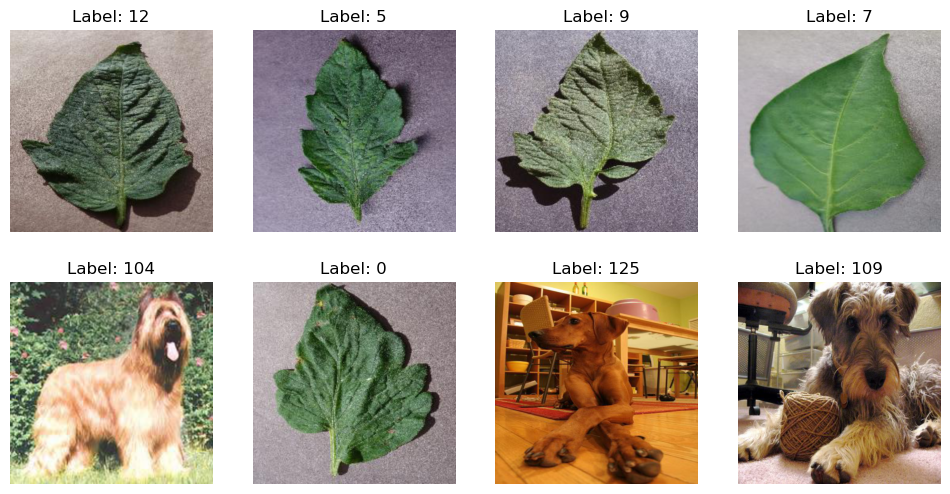

In [568]:
# Function to display a batch of labeled images with labels
def show_labeled_batch(data_loader):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        # https://stackoverflow.com/questions/65676151/how-does-torchvision-transforms-normalize-operate
        img = (img * torch.as_tensor(IMAGENET_DEFAULT_STD)) + torch.as_tensor(IMAGENET_DEFAULT_MEAN)
        plt.imshow(img)
        plt.title(f'Label: {labels[idx].item()}')
        plt.axis('off')
    plt.show()

# Function to display a batch of unlabeled images
def show_unlabeled_batch(data_loader):
    images = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        img = (img * torch.as_tensor(IMAGENET_DEFAULT_STD)) + torch.as_tensor(IMAGENET_DEFAULT_MEAN)
        plt.imshow(img)
        plt.title("Unlabeled Image")
        plt.axis('off')
    plt.show()

# Display a batch of labeled images
print("Labeled images:")
show_labeled_batch(labeled_train_data)
pass

# # Display a batch of unlabeled images
# print("Unlabeled images:")
# show_unlabeled_batch(unlabeled_loader)


In [569]:
# distilled model 
if training_config.get("model", "") == "deit_distilled":
    model = torch.hub.load('facebookresearch/deit:main', 'deit_base_distilled_patch16_224', pretrained=True)
# higher res model
elif training_config.get("model", "") == "deit_384":
    model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_384', pretrained=True)
else: 
    # https://pytorch.org/tutorials/beginner/vt_tutorial.html
    model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [570]:
# Modify the final layer to match the number of classes
num_classes = len(categories)  # Adjust to the actual number of classes
model.head = nn.Linear(model.head.in_features, num_classes)
if training_config.get("model", "") == "deit_distilled":
    model.head_dist = nn.Linear(model.head_dist.in_features, num_classes) # Modify distilled head for distilled model

In [571]:
# https://www.kaggle.com/code/pdochannel/vision-transformers-in-pytorch-deit/notebook
criterion = LabelSmoothingCrossEntropy()
# criterion = criterion.to(device)
if not "optimizer_type" in training_config or training_config["optimizer_type"] == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=training_config["optimizer_lr"], weight_decay=training_config["optimizer_wd"])
elif training_config["optimizer_type"] == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr=training_config["optimizer_lr"], weight_decay=training_config["optimizer_wd"])
else:
    raise NotImplementedError()
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)


In [572]:
def freeze_by_list(model, unfrozen):
    # https://stackoverflow.com/questions/62523912/freeze-certain-layers-of-an-existing-model-in-pytorch
    total_unfrozen = 0
    for name, param in model.named_parameters():
        if name in unfrozen:
            total_unfrozen += 1
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

if "unfreeze_layers" in training_config:
    freeze_by_list(model, training_config["unfreeze_layers"])

[(i[0], i[1].requires_grad) for i in model.named_parameters()]

[('cls_token', False),
 ('pos_embed', False),
 ('patch_embed.proj.weight', False),
 ('patch_embed.proj.bias', False),
 ('blocks.0.norm1.weight', False),
 ('blocks.0.norm1.bias', False),
 ('blocks.0.attn.qkv.weight', False),
 ('blocks.0.attn.qkv.bias', False),
 ('blocks.0.attn.proj.weight', False),
 ('blocks.0.attn.proj.bias', False),
 ('blocks.0.norm2.weight', False),
 ('blocks.0.norm2.bias', False),
 ('blocks.0.mlp.fc1.weight', False),
 ('blocks.0.mlp.fc1.bias', False),
 ('blocks.0.mlp.fc2.weight', False),
 ('blocks.0.mlp.fc2.bias', False),
 ('blocks.1.norm1.weight', False),
 ('blocks.1.norm1.bias', False),
 ('blocks.1.attn.qkv.weight', False),
 ('blocks.1.attn.qkv.bias', False),
 ('blocks.1.attn.proj.weight', False),
 ('blocks.1.attn.proj.bias', False),
 ('blocks.1.norm2.weight', False),
 ('blocks.1.norm2.bias', False),
 ('blocks.1.mlp.fc1.weight', False),
 ('blocks.1.mlp.fc1.bias', False),
 ('blocks.1.mlp.fc2.weight', False),
 ('blocks.1.mlp.fc2.bias', False),
 ('blocks.2.norm1.weig

In [573]:
# lr scheduler
if "scheduler_type" in training_config:
    if training_config["scheduler_type"] == "StepLR":
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, **training_config["scheduler_params"])
    if training_config["scheduler_type"] == "ExponentialLR":
        lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, **training_config["scheduler_params"])
    if training_config["scheduler_type"] == "ReduceLROnPlateau":
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **training_config["scheduler_params"])
    if training_config["scheduler_type"] == "CosineAnnealingWarmRestarts":
        lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, **training_config["scheduler_params"])
else:
    lr_scheduler = None
print(lr_scheduler)

In [574]:
model_path = os.path.join(model_prefix, training_config["model_name"])
os.makedirs(model_path, exist_ok=True)

In [575]:
num_epochs = 15  # Adjust as needed

In [576]:
model.to(device)
start_epoch = 0
hist = TrainingHistory()
misclassified_samples = []

checkpoint_path = os.path.join(model_path, "checkpoint.pth")
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, lr_scheduler, device=device)
    hist.load(os.path.join(model_path, "history.json"))

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm.tqdm(labeled_train_data, desc=f"Train ({epoch+1}/{num_epochs})"):
        images, labels = images.to(device), labels.to(device)

        if training_config.get("augment_mode", "") == "augment":
            # Apply MixUp or CutMix
            if np.random.rand() < 0.5:  # Use MixUp
                images, y_a, y_b, lam = mixup_data(images, labels, alpha=1.0)
            else:  # Use CutMix
                images, y_a, y_b, lam = cutmix_data(images, labels, alpha=1.0)

        # Forward pass
        outputs = model(images)

        if training_config.get("model", "") == "deit_distilled":
        # Extract the primary logits for distilled model
            outputs = outputs[0]
        
        if training_config.get("augment_mode", "") == "augment":
            # Compute loss
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        else: 
            loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

        
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    for i, (images, labels) in enumerate(tqdm.tqdm(labeled_val_data, desc=f"Validation ({epoch+1}/{num_epochs})")):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Track statistics
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()

        # Identify misclassified samples
        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in incorrect_indices:
            misclassified_samples.append({
                "index": idx.item() + i * len(images),  # Adjust for batch index
                "true_label": labels[idx].item(),
                "predicted_label": predicted[idx].item()
            })
    
    if training_config["scheduler_type"] == "ReduceLROnPlateau":
        lr_scheduler.step(val_loss)
    elif lr_scheduler:
        lr_scheduler.step()

    hist.append(train_loss/train_total, val_loss/val_total, train_correct/train_total, val_correct/val_total)
    
    tmp_checkpoint_path = os.path.join(model_path, f"checkpoint-{epoch}.pth")
    save_checkpoint(tmp_checkpoint_path, epoch + 1, model, optimizer, lr_scheduler)
    shutil.copyfile(tmp_checkpoint_path, os.path.join(model_path, f"checkpoint.pth"))
    if hist.is_best():
        shutil.copyfile(tmp_checkpoint_path, os.path.join(model_path, f"checkpoint-best.pth"))
    os.unlink(tmp_checkpoint_path)

    hist.save(os.path.join(model_path, "history.json"))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/train_total:.6f}, Val Loss: {val_loss/val_total:.6f}")
    print(f"      Train Accuracy: {100 * train_correct/train_total:.2f}%, Val Accuracy: {100 * val_correct/val_total:.2f}%")
    print(f"      New LR={[g['lr'] for g in optimizer.param_groups]}")


Validation (1/15): 100%|██████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch [1/15], Train Loss: 0.106838, Val Loss: 0.064927
      Train Accuracy: 80.17%, Val Accuracy: 94.01%
      New LR=[8e-05]


Validation (2/15): 100%|██████████| 62/62 [00:13<00:00,  4.50it/s]


Epoch [2/15], Train Loss: 0.058890, Val Loss: 0.062115
      Train Accuracy: 97.29%, Val Accuracy: 95.63%
      New LR=[6.400000000000001e-05]


Validation (3/15): 100%|██████████| 62/62 [00:13<00:00,  4.50it/s]


Epoch [3/15], Train Loss: 0.055733, Val Loss: 0.060874
      Train Accuracy: 98.49%, Val Accuracy: 95.84%
      New LR=[5.120000000000001e-05]


Validation (4/15): 100%|██████████| 62/62 [00:13<00:00,  4.48it/s]


Epoch [4/15], Train Loss: 0.054239, Val Loss: 0.060804
      Train Accuracy: 99.08%, Val Accuracy: 95.84%
      New LR=[4.0960000000000014e-05]


Validation (5/15): 100%|██████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch [5/15], Train Loss: 0.053345, Val Loss: 0.060588
      Train Accuracy: 99.55%, Val Accuracy: 96.14%
      New LR=[3.2768000000000016e-05]


Validation (6/15): 100%|██████████| 62/62 [00:13<00:00,  4.49it/s]


Epoch [6/15], Train Loss: 0.052830, Val Loss: 0.061151
      Train Accuracy: 99.73%, Val Accuracy: 95.43%
      New LR=[2.6214400000000015e-05]


Validation (7/15): 100%|██████████| 62/62 [00:13<00:00,  4.52it/s]


Epoch [7/15], Train Loss: 0.052442, Val Loss: 0.060543
      Train Accuracy: 99.84%, Val Accuracy: 95.43%
      New LR=[2.0971520000000012e-05]


Validation (8/15): 100%|██████████| 62/62 [00:13<00:00,  4.61it/s]


Epoch [8/15], Train Loss: 0.052195, Val Loss: 0.060608
      Train Accuracy: 99.90%, Val Accuracy: 95.74%
      New LR=[1.677721600000001e-05]


Validation (9/15): 100%|██████████| 62/62 [00:13<00:00,  4.52it/s]


Epoch [9/15], Train Loss: 0.052026, Val Loss: 0.060576
      Train Accuracy: 99.92%, Val Accuracy: 95.94%
      New LR=[1.3421772800000009e-05]


Validation (10/15): 100%|██████████| 62/62 [00:13<00:00,  4.60it/s]


Epoch [10/15], Train Loss: 0.051885, Val Loss: 0.060734
      Train Accuracy: 99.92%, Val Accuracy: 95.63%
      New LR=[1.0737418240000008e-05]


Validation (11/15): 100%|██████████| 62/62 [00:13<00:00,  4.48it/s]


Epoch [11/15], Train Loss: 0.051801, Val Loss: 0.060673
      Train Accuracy: 99.91%, Val Accuracy: 95.63%
      New LR=[8.589934592000007e-06]


Validation (12/15): 100%|██████████| 62/62 [00:13<00:00,  4.51it/s]


Epoch [12/15], Train Loss: 0.051714, Val Loss: 0.060735
      Train Accuracy: 99.93%, Val Accuracy: 95.53%
      New LR=[6.871947673600007e-06]


Validation (13/15): 100%|██████████| 62/62 [00:13<00:00,  4.51it/s]


Epoch [13/15], Train Loss: 0.051660, Val Loss: 0.060759
      Train Accuracy: 99.92%, Val Accuracy: 95.33%
      New LR=[5.4975581388800055e-06]


Validation (14/15): 100%|██████████| 62/62 [00:13<00:00,  4.52it/s]


Epoch [14/15], Train Loss: 0.051617, Val Loss: 0.060894
      Train Accuracy: 99.92%, Val Accuracy: 95.63%
      New LR=[4.3980465111040045e-06]


Validation (15/15): 100%|██████████| 62/62 [00:13<00:00,  4.53it/s]


Epoch [15/15], Train Loss: 0.051572, Val Loss: 0.060768
      Train Accuracy: 99.92%, Val Accuracy: 95.84%
      New LR=[3.5184372088832037e-06]


In [577]:
from collections import Counter
# Count misclassifications per true label
misclassified_counts = Counter(sample['true_label'] for sample in misclassified_samples)

# Sort by the most misclassified
sorted_misclassifications = misclassified_counts.most_common()

# Display sorted misclassified categories
print("\nMost Misclassified Categories:")
for label, count in sorted_misclassifications:
    print(f"True Label: {label}, Misclassified Count: {count}")

# Optional: Display detailed misclassified samples for each category
print("\nMisclassified Samples (Detailed):")
for label, count in sorted_misclassifications:
    print(f"\nTrue Label: {label} (Misclassified {count} times):")
    for sample in misclassified_samples:
        if sample['true_label'] == label:
            print(f"  Index: {sample['index']}, Predicted Label: {sample['predicted_label']}")


Most Misclassified Categories:
True Label: 6, Misclassified Count: 41
True Label: 45, Misclassified Count: 38
True Label: 87, Misclassified Count: 34
True Label: 1, Misclassified Count: 31
True Label: 18, Misclassified Count: 30
True Label: 29, Misclassified Count: 29
True Label: 105, Misclassified Count: 28
True Label: 119, Misclassified Count: 25
True Label: 4, Misclassified Count: 24
True Label: 0, Misclassified Count: 23
True Label: 109, Misclassified Count: 21
True Label: 122, Misclassified Count: 19
True Label: 8, Misclassified Count: 18
True Label: 73, Misclassified Count: 17
True Label: 117, Misclassified Count: 16
True Label: 66, Misclassified Count: 15
True Label: 82, Misclassified Count: 15
True Label: 68, Misclassified Count: 15
True Label: 12, Misclassified Count: 15
True Label: 103, Misclassified Count: 15
True Label: 130, Misclassified Count: 15
True Label: 88, Misclassified Count: 15
True Label: 57, Misclassified Count: 15
True Label: 120, Misclassified Count: 14
True 

Text(0.5, 0, 'Epoch')

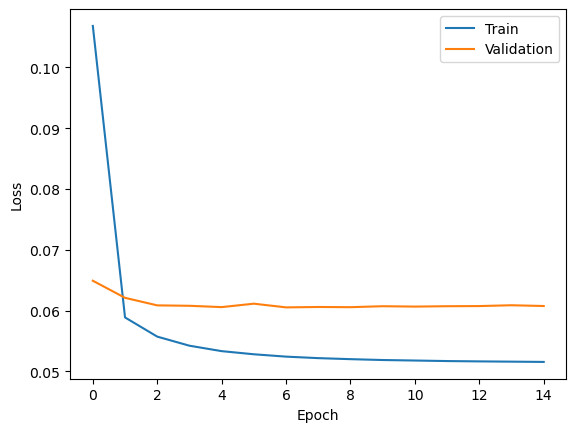

In [578]:
# Plot Loss
plt.plot(range(len(hist.train_loss)), hist.train_loss, label="Train")
plt.plot(range(len(hist.val_loss)), hist.val_loss, label="Validation")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

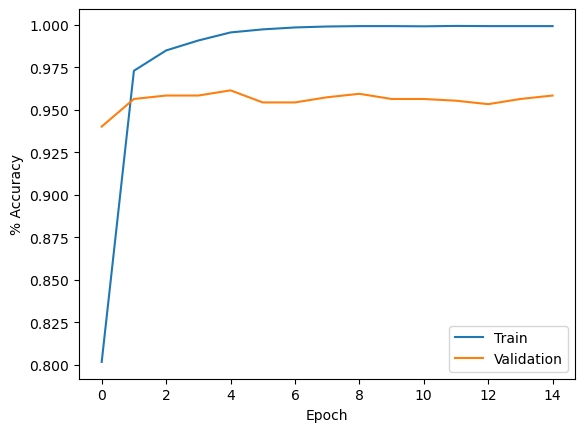

In [579]:
# Plot Accuracy
plt.plot(range(len(hist.train_acc)), hist.train_acc, label="Train")
plt.plot(range(len(hist.val_acc)), hist.val_acc, label="Validation")
plt.legend()
plt.ylabel("% Accuracy")
plt.xlabel("Epoch")

In [580]:
raise "STOP"

TypeError: exceptions must derive from BaseException

In [581]:
test_dataset = ImageDataset(root_dir=os.path.join(data_prefix,'test'), return_filenames=True, transform=transform)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True)

In [582]:
import csv

def create_csv_with_number(base_name, data):
    """Creates a CSV file with a unique number in the filename if the file already exists."""

    file_number = 1
    file_name = f"{base_name}.csv"

    while os.path.exists(file_name):
        file_name = f"{base_name}_{file_number}.csv"
        file_number += 1

    # Save to CSV
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["image", "id"])  # Write header
        writer.writerows(data)  # Write predictions

    print(f"File '{file_name}' created and results saved successfully.")

In [583]:
hist = None
best_checkpoint_path = os.path.join(model_path, "checkpoint-best.pth")
best_epoch = load_checkpoint(best_checkpoint_path, model, optimizer, lr_scheduler, device=device)
print(best_checkpoint_path)
print("Best epoch:", best_epoch)

model.to(device)
model.eval()
results = []

with torch.no_grad():
    for images, filenames in tqdm.tqdm(test_data, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)  # Get the predicted class IDs

        # Store filename and predicted label
        results.extend(zip(filenames, predicted.cpu().numpy()))

create_csv_with_number("test_submission", results)

/tmp/ipykernel_1480/2032433435.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


/mnt/c/Users/Michelle Quach/Desktop/UCSC/CSE244A/CSE244A-Final-Project/CSE244A-Final-Project/ucsc-cse-244-a-2024-fall-final-project/models/michelle_diet384_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4/checkpoint-best.pth
Best epoch: 7


Testing: 100%|██████████| 514/514 [01:53<00:00,  4.54it/s]

File 'test_submission_3.csv' created and results saved successfully.
